In [1]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import MCMTGate, ZGate, GroverOperator
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit_ibm_runtime import SamplerV2 as Sampler, Session
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution

from typing import Union
import random
import math

class MMGame:
    def __init__(self, code_length: int=4, secret_code: str=None, replace: bool=False):
        """ Initialize game with code length, optional secret, and replace mode """
        self.colours: dict[str, str] = {'R': 'Red', 'O':'Orange', 'Y':'Yellow',
                                       'G':'GREEN', 'B':'Blue', 'I':'Indigo'}
        self.code_length: int = code_length
        self.all_codes: list[str] = self._generate_all_codes(replace=replace)
        self.secret_code: str = secret_code if secret_code else random.choice(self.all_codes)

    def _generate_all_codes(self, replace: bool=False) -> list[str]:
        """ Generate all possible codes with or without replacement."""
        from itertools import permutations, product
        if replace:
            return [''.join(p) for p in product(self.colours.keys(), repeat=self.code_length)]
        else:
            return [''.join(p) for p in permutations(self.colours.keys(), self.code_length)]

In [2]:

class QuantumMMSolver:
    def __init__(self, mm_game: MMGame, backend: str='AER'):
        """ Initialize solver with game instance and mappings """
        self.mm_game: MMGame = mm_game
        self.num_solutions = 1
        self.char_bits: int = 3
        self.code_bits: int = self.char_bits * self.mm_game.code_length
        self.colour_to_bin = {
            c: format(i, f'0{self.char_bits}b')
            for i, c in enumerate(mm_game.colours)
        }
        self.bin_to_colour = {v: k for k, v in self.colour_to_bin.items()}
        self.solved: bool = False
        self.oracle: Union[PhaseOracle, QuantumCircuit] = None
        self.isa_circuit = None
        if backend.upper() == 'AER':
            self.backend = AerSimulator()
        elif backend.upper() == 'FAKE':
            self.backend = FakeAlmadenV2()
        elif backend.upper() == 'IBM':
            self.backend = QiskitRuntimeService().least_busy(operational=True, simulator=False)            

    def _iterations(self, number: int=None, imax: int=10, imin: int=3) -> int:
        """ Compute clamped number of Grover iterations based on remaining solutions """
        if number:
            return number
        i = math.floor(
            math.pi / 
            (4 * math.asin(math.sqrt(self.num_solutions / 2**self.code_bits)))
        )
        return max(imin, min(i, imax))

    def encode(self, code: str) -> str:
        """ Convert colour code string into binary bitstring """
        return ''.join(self.colour_to_bin[c] for c in code)

    def decode(self, bitstring: Union[int, str]) -> str:
        """ Convert binary bitstring or integer into colour code string """
        if isinstance(bitstring, int):
            bitstring = format(bitstring, f"0{self.code_bits}b")
        return ''.join(
            self.bin_to_colour[bitstring[i:i+self.char_bits]]
            for i in range(0, len(bitstring), self.char_bits)
        )

    @staticmethod
    def _bitstrings_to_formula(bitstrings: list[str]) -> str:
        """
        Convert bitstring list to logical formula. Use with PhaseOracle.
        e.g ["101...", "010...", ...] => (q0 & ~q1 & q2 & ...) | (...)
        """
        terms = []
        for bstring in bitstrings:
            bits = []
            for idx, bit in enumerate(bstring):
                t = '' if bit == '1' else '~'
                bits.append(f'{t}q{idx}')
            term = '(' + ' & '.join(bits) + ')'
            terms.append(term)
        return ' | '.join(terms)

    def build_oracle(self, log: bool=False, phase_oracle: bool=False):
        """ Build Grover oracle circuit using either PhaseOracle or manual gates """
        solution_bitstring = self.encode(self.mm_game.secret_code)[::-1]
        if phase_oracle:
            logical_formula = self._bitstrings_to_formula([solution_bitstring])
            self.oracle = PhaseOracle(logical_formula)
        else:
            n = self.code_bits
            qc = QuantumCircuit(n)
            zeros = [i for i, bit in enumerate(solution_bitstring) if bit == '0']
            qc.x(zeros)
            qc.compose(MCMTGate(ZGate(), n - 1, 1), inplace=True)
            qc.x(zeros)
            self.oracle = qc
        if log:
            print("Oracle depth:", self.oracle.decompose().depth())
            print("Oracle size (gate count):", self.oracle.size())
            print("Oracle width (qubits used):", self.oracle.width())

    def build_backend(self, iterations: int=None, log: bool=False):
        """ Compose and build Grover circuit for execution on backend """
        if log:
            print(f"Backend selected: {self.backend.name} with {self.backend.num_qubits} qubits")
            print("Compose Grover operator...")
        grover_op = GroverOperator(self.oracle)
        qc = QuantumCircuit(self.code_bits)
        qc.h(range(self.code_bits))
        qc.compose(grover_op.power(self._iterations(iterations)), inplace=True)
        qc.measure_all()
        if log:
            print(f"Circuit composed: iterations={self._iterations(iterations)}")
       
        pm = generate_preset_pass_manager(backend=self.backend, optimization_level=1)
        self.isa_circuit = pm.run(qc)
        if log:
            print("Grover circuit depth:", self.isa_circuit.depth())
            print("Grover circuit size (gate count):", self.isa_circuit.size())
            print("Grover circuit width (qubits used):", self.isa_circuit.width())

    def run_grover(self, shots: int=10_000) -> dict[str, int]:
        """ Execute Grover circuit using V2 sampler and return measurement counts """
        self.isa_circuit.draw()
        with Session(backend=self.backend) as session:
            sampler = Sampler()
            results = sampler.run([self.isa_circuit]).result()
            return results[0].data.meas.get_counts()


Total permutations: 1296
Secret: IRYY
Oracle depth: 3
Oracle size (gate count): 1
Oracle width (qubits used): 12
Backend selected: aer_simulator with 30 qubits
Compose Grover operator...
Circuit composed: iterations=10
Grover circuit depth: 42
Grover circuit size (gate count): 283
Grover circuit width (qubits used): 24


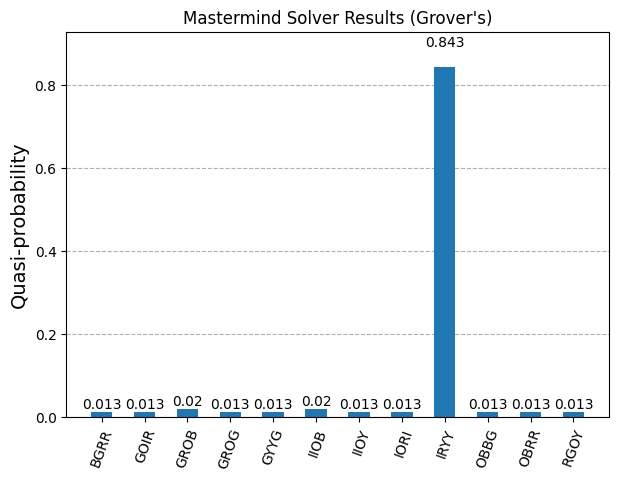

In [3]:
# Set up game and solver
mm = MMGame(replace=True, code_length=4)  # secret_code="BGRY")
solver = QuantumMMSolver(mm, backend='Aer')
print(f"Total permutations: {len(mm.all_codes)}")
print(f"Secret: {mm.secret_code}")

# Build oracle circuit
solver.build_oracle(phase_oracle=True, log=True)

# Build backend 
solver.build_backend(log=True, iterations=None)

# Run Grover
counts = solver.run_grover() 

def is_valid_result(bits):
    """ Filter results ensuring within range of game colours """
    if isinstance(bits, int):  
        bits = format(bits, f"0{solver.code_bits}b")
    bitstrings = [bits[i:i+solver.char_bits] for i in range(0, len(bits), solver.char_bits)]
    result = all(int(b, 2) < len(solver.mm_game.colours) for b in bitstrings)
    return result

valid_counts = {b: c for b, c in counts.items() if is_valid_result(b)}

top = dict(sorted(valid_counts.items(), key=lambda x: -x[1])[:12])
decoded_top = {}
for k, v in top.items():
    # for simulator: convert from integer
    if isinstance(k, int):
        bitstring = format(k, f"0{solver.code_bits}b")
    else:
        bitstring = k          # for Simulators: same endianness
        # bitstring = k[::-1]  # for mocked backend and IBM Quantum: big-endian bitstring

    code = solver.decode(bitstring)
    decoded_top[code] = v
        
plot_distribution(decoded_top, title="Mastermind Solver Results (Grover's)")